In [1]:
import sys
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt

print("Python version:", sys.version)
print("NumPy version:", np.__version__)
print("OpenCV version:", cv2.__version__)
print("Matplotlib version:", matplotlib.__version__)

Python version: 3.11.4 (main, Jul  5 2023, 08:54:11) [Clang 14.0.6 ]
NumPy version: 1.24.3
OpenCV version: 4.8.1
Matplotlib version: 3.6.0


Colorizing the image


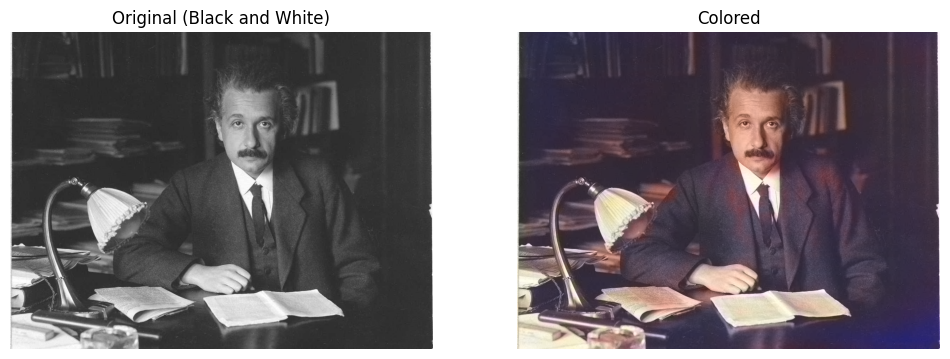

Colorizing the image


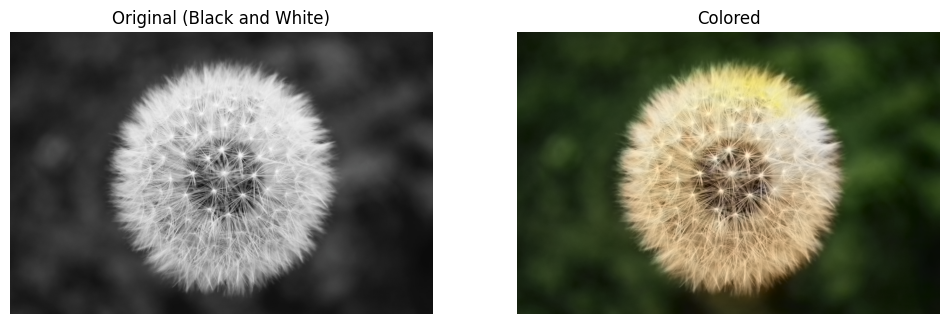

In [2]:
# Paths to load the model
PROTOTXT = 'model/colorization_deploy_v2.prototxt'
POINTS = 'model/pts_in_hull.npy'

# Download the model https://www.dropbox.com/s/dx0qvhhp5hbcx7z/colorization_release_v2.caffemodel?dl=1
MODEL = 'model/colorization_release_v2.caffemodel' 

# Load the Model
net = cv2.dnn.readNetFromCaffe(PROTOTXT, MODEL)
pts = np.load(POINTS)

# Load centers for ab channel quantization used for rebalancing.
class8 = net.getLayerId("class8_ab")
conv8 = net.getLayerId("conv8_313_rh")
pts = pts.transpose().reshape(2, 313, 1, 1)
net.getLayer(class8).blobs = [pts.astype("float32")]
net.getLayer(conv8).blobs = [np.full([1, 313], 2.606, dtype="float32")]

def colorize_image(image_path):
    # Load the input image
    image = cv2.imread(image_path)
    scaled = image.astype("float32") / 255.0
    lab = cv2.cvtColor(scaled, cv2.COLOR_BGR2LAB)

    resized = cv2.resize(lab, (224, 224))
    L = cv2.split(resized)[0]
    L -= 50

    print("Colorizing the image")
    net.setInput(cv2.dnn.blobFromImage(L))
    ab = net.forward()[0, :, :, :].transpose((1, 2, 0))

    ab = cv2.resize(ab, (image.shape[1], image.shape[0]))

    L = cv2.split(lab)[0]
    colorized = np.concatenate((L[:, :, np.newaxis], ab), axis=2)

    colorized = cv2.cvtColor(colorized, cv2.COLOR_LAB2BGR)
    colorized = np.clip(colorized, 0, 1)

    colorized = (255 * colorized).astype("uint8")

    return colorized

# Function to display images inline in the notebook
def display_images(original, colored):
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title('Original (Black and White)')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(colored, cv2.COLOR_BGR2RGB))
    plt.title('Colored')
    plt.axis('off')
    
    plt.show()

# Example usage
image_path = 'images/einstein.jpg'  # Path to the black and white image
original_image = cv2.imread(image_path)
colored_image = colorize_image(image_path)
display_images(original_image, colored_image)

image_path = 'images/pexels-j-h-21323.jpg'  # Path to the black and white image
original_image = cv2.imread(image_path)
colored_image = colorize_image(image_path)
display_images(original_image, colored_image)
